<a href="https://colab.research.google.com/github/datle2403/datle2403/blob/main/Generative_Adversarial_Networks_for_Synthesizing_New_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autoencoder

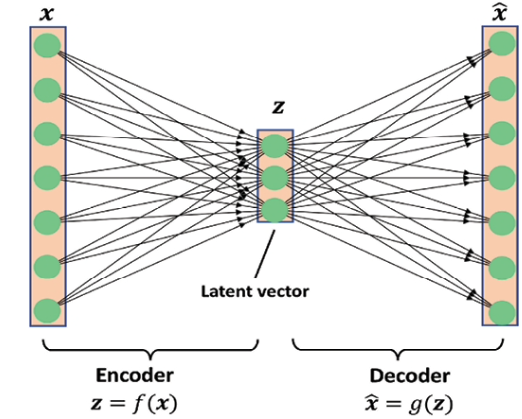

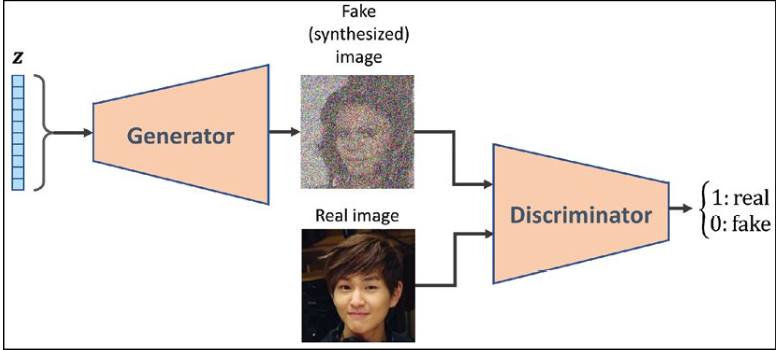

z is a sample that taking from a population that has standard normally distributed or uniform distributed. We do that by using VAEs

x~ is the output (G(z)).

During training, the decoder produce an image, then the assessor function check the quality of that image. that function is an neuron network, called discrimniator

In GAN model, the generator and discriminator are trained together. 

Loss function is defined as:
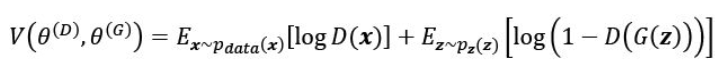

this is called value function, we want to maximize the discriminator(D) w.r.t value function and minimized the generator(G) w.r.t value function

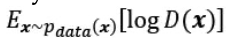

refer to expected value of the quantity in bracket w.r.t the example from the data distribution (distribution of the real example).
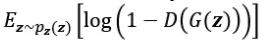

this refer to the expected value of the quantity w.r.t distribution of the input z, vectors

one training step involve 2 steps: (1) maximize the payoff for the discriminator, (2) minimize the payoff for the generator(G). Fix(frezze) the first network and optimize other network and vice versa. This process should repeated at each training iteration

For example, we want to optimize the discriminator(D), the 2nd NN is fixed. the value function contribute both term to optimize, where the 1st term for the lost associate to the real image, 2nd term for the lost associate to fake image

then we fix the D and optimize the generator(G), in this case only the 2nd term contribute to 

As we want the generator to synthesize realistic images, we want to penalize the generator when its output are not classified as real by discriminator

In [ ]:
import tensorflow as tf
tf.__version__

'2.9.2'

In [ ]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Individual step of GANs

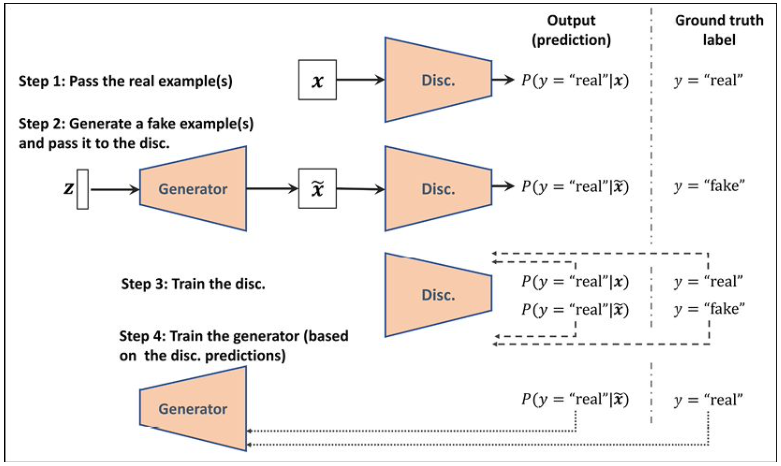

# Implementing the generator and the discriminator networks

the original GANs refer to vanilla GAN
 

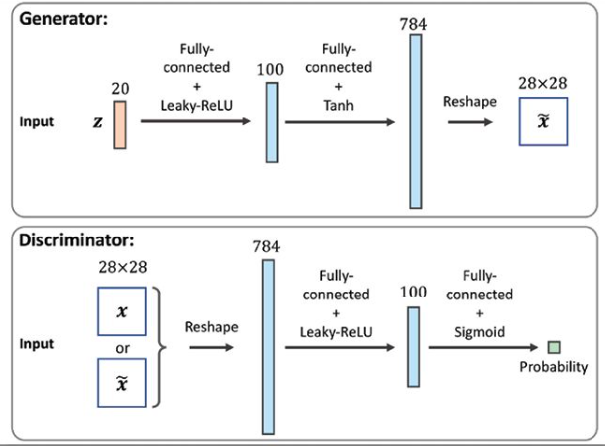

Leaky ReLU: allow non-zero negative input as well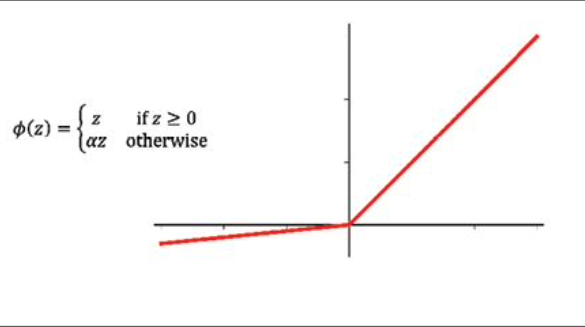

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
def make_generator_network(num_hidden_units=100, num_hidden_layers=1, num_output_units=784):
  model=tf.keras.Sequential()
  for i in range(num_hidden_layers):
    model.add(tf.keras.layers.Dense(units=num_hidden_units, use_bias=False))
    model.add(tf.keras.layers.LeakyReLU())
  model.add(tf.keras.layers.Dense(units=num_output_units, activation='tanh'))
  return model
def make_discriminator_network(num_hidden_units=100, num_hidden_layers=1, num_output_units=1):
  model=tf.keras.Sequential()
  for i in range(num_hidden_layers):
    model.add(tf.keras.layers.Dense(units=num_hidden_units, use_bias=False))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(rate=0.5))
  model.add(tf.keras.layers.Dense(units=num_output_units, activation=None))
  return model

In [ ]:
image_size=(28,28)
z_size=20
mode_z= 'uniform'
gen_hidden_layers = 1
gen_hidden_size= 100
disc_hidden_layer=1
disc_hidden_size=100
tf.random.set_seed(1)
gen_model=make_generator_network(units_hidden= gen_hidden_size, num_hidden= gen_hidden_layers, num_output_units= np.prod(image_size))
gen_model.build(input_shape=(None, z_size))
gen_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               2000      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 784)               79184     
                                                                 
Total params: 81,184
Trainable params: 81,184
Non-trainable params: 0
_________________________________________________________________


In [ ]:
disc_model= make_discriminator_network(units_hidden= disc_hidden_size, num_hidden= disc_hidden_layer)
disc_model.build(input_shape=(None, np.prod(image_size)))
disc_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 100)               78400     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 100)               0         
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                                 
Total params: 78,501
Trainable params: 78,501
Non-trainable params: 0
_________________________________________________________________


In [ ]:
mnist= tfds.builder('mnist')
mnist.download_and_prepare()
mnist= mnist.as_dataset(shuffle_files=False)
mnist

Dl Completed...:   0%|          | 0/4 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to ~/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


{'test': <PrefetchDataset element_spec={'image': TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>,
 'train': <PrefetchDataset element_spec={'image': TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>}

In [ ]:
def preprocess(ex, mode='uniform'):
  image= ex['image']
  image= tf.image.convert_image_dtype(image, tf.float32) # change from uint8 into float32(0,1)
  image= tf.reshape(image,[-1])
  image= image*2 -1.0 # make to range (-1,1)

  if mode== 'uniform':
    input_z= tf.random.uniform(shape=(z_size,), minval=-1.0, maxval=1.0)
  elif mode=='normal':
    input_z= tf.random.normal(shape=(z_size,))
  return input_z, image

In [ ]:
mnist_train= mnist['train'].map(preprocess)
mnist_test= mnist['test'].map(preprocess)

mnist_trainset= mnist_train.batch(32, drop_remainder=True)
input_z, input_real=  next(iter(mnist_trainset))
input_real.shape

TensorShape([32, 784])

In [ ]:
input_z= tf.random.normal(shape=(z_size,))
input_z

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([ 0.6118191 ,  0.49197587,  2.1795328 ,  0.8756376 , -0.6439091 ,
       -0.19038413, -0.11978462, -1.3319352 ,  1.8938745 , -1.2925854 ,
        0.6219484 ,  0.43233466, -1.1556841 , -1.1534997 ,  0.86862946,
        0.3044792 ,  0.27210107, -0.69824773, -1.0841647 , -1.5928216 ],
      dtype=float32)>

In [ ]:
g_output= gen_model(input_z)

In [ ]:
d_logit_fake= disc_model(g_output)

In [ ]:
d_logit_real= disc_model(input_real)

In [ ]:
loss_fn=  tf.keras.losses.BinaryCrossentropy(from_logits=True)
# for generator loss
g_label_real= tf.ones_like(d_logit_fake) # None,1
g_loss=  loss_fn(y_true= g_label_real, y_pred= d_logit_fake)
# for discriminator loss
d_label_real= tf.ones_like(d_logit_real)
d_label_fake= tf.zeros_like(d_logit_fake)
d_loss_real= loss_fn(d_label_real,d_logit_real)
d_loss_fake= loss_fn(d_label_fake,d_logit_fake)
print(d_loss_real.numpy(), d_loss_fake.numpy())

1.5073311 0.6583027


In [ ]:
import time
device_name = tf.test.gpu_device_name()

num_epochs = 100
batch_size = 64
image_size = (28, 28)
z_size = 20
mode_z = 'uniform'
gen_hidden_layers = 1
gen_hidden_size = 100
disc_hidden_layers = 1
disc_hidden_size = 100

tf.random.set_seed(1)
np.random.seed(1)


if mode_z == 'uniform':
    fixed_z = tf.random.uniform(
        shape=(batch_size, z_size),
        minval=-1, maxval=1)
elif mode_z == 'normal':
    fixed_z = tf.random.normal(
        shape=(batch_size, z_size))


def create_samples(g_model, input_z):
    g_output = g_model(input_z, training=False)
    images = tf.reshape(g_output, (batch_size, *image_size))    
    return (images+1)/2.0

## Set-up the dataset
mnist_trainset = mnist['train']
mnist_trainset = mnist_trainset.map(
    lambda ex: preprocess(ex, mode=mode_z))

mnist_trainset = mnist_trainset.shuffle(10000)
mnist_trainset = mnist_trainset.batch(
    batch_size, drop_remainder=True)

## Set-up the model
with tf.device(device_name):
    gen_model = make_generator_network(
        num_hidden_layers=gen_hidden_layers, 
        num_hidden_units=gen_hidden_size,
        num_output_units=np.prod(image_size))
    gen_model.build(input_shape=(None, z_size))

    disc_model = make_discriminator_network(
        num_hidden_layers=disc_hidden_layers,
        num_hidden_units=disc_hidden_size)
    disc_model.build(input_shape=(None, np.prod(image_size)))

## Loss function and optimizers:
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)
g_optimizer = tf.keras.optimizers.Adam()
d_optimizer = tf.keras.optimizers.Adam()

all_losses = []
all_d_vals = []
epoch_samples = []

start_time = time.time()
for epoch in range(1, num_epochs+1):
    epoch_losses, epoch_d_vals = [], []
    for i,(input_z,input_real) in enumerate(mnist_trainset):
        
        ## Compute generator's loss
        with tf.GradientTape() as g_tape:
            g_output = gen_model(input_z)
            d_logits_fake = disc_model(g_output, training=True)
            labels_real = tf.ones_like(d_logits_fake)
            g_loss = loss_fn(y_true=labels_real, y_pred=d_logits_fake)
            
        g_grads = g_tape.gradient(g_loss, gen_model.trainable_variables)
        g_optimizer.apply_gradients(
            grads_and_vars=zip(g_grads, gen_model.trainable_variables))

        ## Compute discriminator's loss
        with tf.GradientTape() as d_tape:
            d_logits_real = disc_model(input_real, training=True)

            d_labels_real = tf.ones_like(d_logits_real)
            
            d_loss_real = loss_fn(
                y_true=d_labels_real, y_pred=d_logits_real)

            d_logits_fake = disc_model(g_output, training=True)
            d_labels_fake = tf.zeros_like(d_logits_fake)

            d_loss_fake = loss_fn(
                y_true=d_labels_fake, y_pred=d_logits_fake)

            d_loss = d_loss_real + d_loss_fake

        ## Compute the gradients of d_loss
        d_grads = d_tape.gradient(d_loss, disc_model.trainable_variables)
        
        ## Optimization: Apply the gradients
        d_optimizer.apply_gradients(
            grads_and_vars=zip(d_grads, disc_model.trainable_variables))
                           
        epoch_losses.append(
            (g_loss.numpy(), d_loss.numpy(), 
             d_loss_real.numpy(), d_loss_fake.numpy()))
        
        d_probs_real = tf.reduce_mean(tf.sigmoid(d_logits_real))
        d_probs_fake = tf.reduce_mean(tf.sigmoid(d_logits_fake))
        epoch_d_vals.append((d_probs_real.numpy(), d_probs_fake.numpy()))        
    all_losses.append(epoch_losses)
    all_d_vals.append(epoch_d_vals)
    print(
        'Epoch {:03d} | ET {:.2f} min | Avg Losses >>'
        ' G/D {:.4f}/{:.4f} [D-Real: {:.4f} D-Fake: {:.4f}]'
        .format(
            epoch, (time.time() - start_time)/60, 
            *list(np.mean(all_losses[-1], axis=0))))
    epoch_samples.append(
        create_samples(gen_model, fixed_z).numpy())

Epoch 001 | ET 0.44 min | Avg Losses >> G/D 1.8241/0.5031 [D-Real: 0.0471 D-Fake: 0.4560]
Epoch 002 | ET 0.88 min | Avg Losses >> G/D 2.5289/0.4524 [D-Real: 0.0864 D-Fake: 0.3661]
Epoch 003 | ET 1.32 min | Avg Losses >> G/D 2.1298/0.5675 [D-Real: 0.1725 D-Fake: 0.3950]
Epoch 004 | ET 1.75 min | Avg Losses >> G/D 1.6836/0.7728 [D-Real: 0.2987 D-Fake: 0.4741]
Epoch 005 | ET 2.19 min | Avg Losses >> G/D 1.8181/0.8357 [D-Real: 0.3769 D-Fake: 0.4589]
Epoch 006 | ET 2.64 min | Avg Losses >> G/D 1.5390/1.0205 [D-Real: 0.4933 D-Fake: 0.5272]
Epoch 007 | ET 3.07 min | Avg Losses >> G/D 1.5701/0.9618 [D-Real: 0.5021 D-Fake: 0.4597]
Epoch 008 | ET 3.50 min | Avg Losses >> G/D 1.5494/1.0716 [D-Real: 0.5544 D-Fake: 0.5172]
Epoch 009 | ET 3.94 min | Avg Losses >> G/D 1.5368/1.0602 [D-Real: 0.5594 D-Fake: 0.5008]
Epoch 010 | ET 4.37 min | Avg Losses >> G/D 1.4320/1.0805 [D-Real: 0.5877 D-Fake: 0.4928]
Epoch 011 | ET 4.80 min | Avg Losses >> G/D 1.2748/1.1544 [D-Real: 0.6237 D-Fake: 0.5307]
Epoch 012 

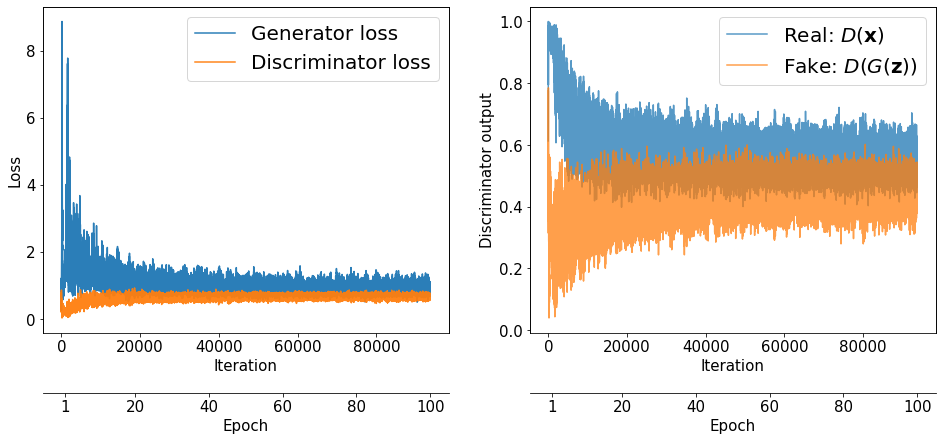

In [ ]:
import itertools


fig = plt.figure(figsize=(16, 6))

## Plotting the losses
ax = fig.add_subplot(1, 2, 1)
g_losses = [item[0] for item in itertools.chain(*all_losses)]
d_losses = [item[1]/2.0 for item in itertools.chain(*all_losses)]
plt.plot(g_losses, label='Generator loss', alpha=0.95)
plt.plot(d_losses, label='Discriminator loss', alpha=0.95)
plt.legend(fontsize=20)
ax.set_xlabel('Iteration', size=15)
ax.set_ylabel('Loss', size=15)

epochs = np.arange(1, 101)
epoch2iter = lambda e: e*len(all_losses[-1])
epoch_ticks = [1, 20, 40, 60, 80, 100]
newpos = [epoch2iter(e) for e in epoch_ticks]
ax2 = ax.twiny()
ax2.set_xticks(newpos)
ax2.set_xticklabels(epoch_ticks)
ax2.xaxis.set_ticks_position('bottom')
ax2.xaxis.set_label_position('bottom')
ax2.spines['bottom'].set_position(('outward', 60))
ax2.set_xlabel('Epoch', size=15)
ax2.set_xlim(ax.get_xlim())
ax.tick_params(axis='both', which='major', labelsize=15)
ax2.tick_params(axis='both', which='major', labelsize=15)

## Plotting the outputs of the discriminator
ax = fig.add_subplot(1, 2, 2)
d_vals_real = [item[0] for item in itertools.chain(*all_d_vals)]
d_vals_fake = [item[1] for item in itertools.chain(*all_d_vals)]
plt.plot(d_vals_real, alpha=0.75, label=r'Real: $D(\mathbf{x})$')
plt.plot(d_vals_fake, alpha=0.75, label=r'Fake: $D(G(\mathbf{z}))$')
plt.legend(fontsize=20)
ax.set_xlabel('Iteration', size=15)
ax.set_ylabel('Discriminator output', size=15)

ax2 = ax.twiny()
ax2.set_xticks(newpos)
ax2.set_xticklabels(epoch_ticks)
ax2.xaxis.set_ticks_position('bottom')
ax2.xaxis.set_label_position('bottom')
ax2.spines['bottom'].set_position(('outward', 60))
ax2.set_xlabel('Epoch', size=15)
ax2.set_xlim(ax.get_xlim())
ax.tick_params(axis='both', which='major', labelsize=15)
ax2.tick_params(axis='both', which='major', labelsize=15)


#plt.savefig('images/ch17-gan-learning-curve.pdf')
plt.show()

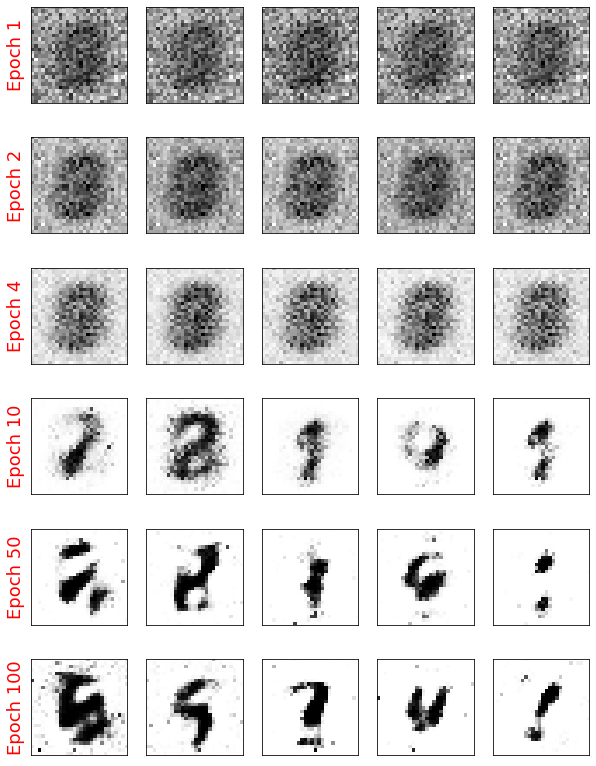

In [ ]:
selected_epochs = [1, 2, 4, 10, 50, 100]
fig = plt.figure(figsize=(10, 14))
for i,e in enumerate(selected_epochs):
    for j in range(5):
        ax = fig.add_subplot(6, 5, i*5+j+1)
        ax.set_xticks([])
        ax.set_yticks([])
        if j == 0:
            ax.text(
                -0.06, 0.5, 'Epoch {}'.format(e),
                rotation=90, size=18, color='red',
                horizontalalignment='right',
                verticalalignment='center', 
                transform=ax.transAxes)
        
        image = epoch_samples[e-1][j]
        ax.imshow(image, cmap='gray_r')
    
#plt.savefig('images/ch17-vanila-gan-samples.pdf')
plt.show()

# WGAN (tham khao thui, ko hiu lam)

In [ ]:
import tensorflow as tf
import numpy as np
def make_dcgan_generator(z_size=20, output_size=(28,28,1), n_filters=128, n_blocks=2):
    size_factor= 2**n_blocks
    hidden_size=(output_size[0]//size_factor, output_size[1]//size_factor)
    model= tf.keras.Sequential([
        tf.keras.Input(shape=(z_size,)),
        tf.keras.layers.Dense(units=n_filters*np.prod(hidden_size), use_bias=False),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Reshape((hidden_size[0],hidden_size[1],n_filters)),

        tf.keras.layers.Conv2DTranspose(filters=n_filters, kernel_size=(5,5), strides=(1,1), padding='same', use_bias=False),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU()
    ])
    nf= n_filters
    for i in range(n_blocks):
        nf=nf//2
        model.add(tf.keras.layers.Conv2DTranspose(filters=nf, kernel_size=(5,5), strides=(2,2),
                                                  padding='same', use_bias=False))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(filters=output_size[2], kernel_size=(5,5), strides=(1,1), padding='same', use_bias=False))
    return model

def make_dcgan_discriminator(input_size=(28,28,1), n_filters=64, n_blocks=2):
    model= tf.keras.Sequential([
        tf.keras.layers.Input(shape=input_size),
        tf.keras.layers.Conv2D(filters=n_filters, kernel_size=5, strides=(1,1), padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU()
    ])
    nf= n_filters
    for i in range(n_blocks):
        nf= nf*2
        model.add(tf.keras.layers.Conv2D(filters=nf, kernel_size=(5,5), strides=(2,2), padding='same'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.LeakyReLU())
        model.add(tf.keras.layers.Dropout(rate=0.3))
    model.add(tf.keras.layers.Conv2D(filters=1, kernel_size=(7,7), padding='valid'))
    model.add(tf.keras.layers.Reshape((1,)))
    return model

def preprocess(ex, mode='uniform'):
    image= ex['image']
    image= tf.image.convert_image_dtype(image, tf.float32)
    image= image*2 -1.0
    if mode=='uniform':
        input_z= tf.random.uniform(shape=(20,), minval=-1.0, maxval=1.0)
    elif mode=='normal':
        input_z= tf.random.normal(shape=(20,))
    return input_z, image




## Implementing WGAN-GP to train the DCGAN model

num_epochs= 100
batch_size= 128
image_size = (28,28)
z_size=20
mode_z= 'uniform'
lambda_gp= 10.0
tf.random.set_seed(1)
np.random.seed(1)

import tensorflow_datasets as tfds
mnist= tfds.builder('mnist')
mnist.download_and_prepare()
mnist= mnist.as_dataset(shuffle_files=False)

mnist_trainset= mnist['train']
mnist_trainset=mnist_trainset.map(preprocess)
mnist_trainset= mnist_trainset.shuffle(10000).batch(batch_size, drop_remainder=True)
device_name = tf.test.gpu_device_name()
with tf.device(device_name):
    gen_model= make_dcgan_generator()
    gen_model.build(input_shape=(None, z_size))

    disc_model = make_dcgan_discriminator()
    disc_model.build(input_shape=(None, np.prod(image_size)))

import time
g_optimizer= tf.keras.optimizers.Adam(0.0002)
d_optimizer= tf.keras.optimizers.Adam(0.0002)
if mode_z == 'uniform':
    fixed_z = tf.random.uniform(
        shape=(batch_size, z_size),
        minval=-1, maxval=1)
elif mode_z == 'normal':
    fixed_z = tf.random.normal(
        shape=(batch_size, z_size))

def create_samples(g_model, input_z):
    g_output = g_model(input_z, training=False)
    images = tf.reshape(g_output, (batch_size, *image_size))    
    return (images+1)/2.0

all_losses = []
epoch_samples = []

start_time = time.time()

for epoch in range(1, num_epochs+1):
    epoch_losses = []
    for i,(input_z,input_real) in enumerate(mnist_trainset):
        
        ## Compute discriminator's loss and gradients:
        with tf.GradientTape() as d_tape, tf.GradientTape() as g_tape:
            g_output = gen_model(input_z, training=True)
            
            d_critics_real = disc_model(input_real, training=True)
            d_critics_fake = disc_model(g_output, training=True)

            ## Compute generator's loss:
            g_loss = -tf.math.reduce_mean(d_critics_fake)

            ## Compute discriminator's losses
            d_loss_real = -tf.math.reduce_mean(d_critics_real)
            d_loss_fake =  tf.math.reduce_mean(d_critics_fake)
            d_loss = d_loss_real + d_loss_fake

            ## Gradient penalty:
            with tf.GradientTape() as gp_tape:
                alpha = tf.random.uniform(
                    shape=[d_critics_real.shape[0], 1, 1, 1], 
                    minval=0.0, maxval=1.0)
                interpolated = (
                    alpha*input_real + (1-alpha)*g_output)
                gp_tape.watch(interpolated)
                d_critics_intp = disc_model(interpolated)
            
            grads_intp = gp_tape.gradient(
                d_critics_intp, [interpolated,])[0]
            grads_intp_l2 = tf.sqrt(
                tf.reduce_sum(tf.square(grads_intp), axis=[1, 2, 3]))
            grad_penalty = tf.reduce_mean(tf.square(grads_intp_l2 - 1.0))
        
            d_loss = d_loss + lambda_gp*grad_penalty
        
        ## Optimization: Compute the gradients apply them
        d_grads = d_tape.gradient(d_loss, disc_model.trainable_variables)
        d_optimizer.apply_gradients(
            grads_and_vars=zip(d_grads, disc_model.trainable_variables))
        
        g_grads = g_tape.gradient(g_loss, gen_model.trainable_variables)
        g_optimizer.apply_gradients(
            grads_and_vars=zip(g_grads, gen_model.trainable_variables))

        epoch_losses.append(
            (g_loss.numpy(), d_loss.numpy(), 
             d_loss_real.numpy(), d_loss_fake.numpy()))
                    
    all_losses.append(epoch_losses)
    
    print('Epoch {:-3d} | ET {:.2f} min | Avg Losses >>'
          ' G/D {:6.2f}/{:6.2f} [D-Real: {:6.2f} D-Fake: {:6.2f}]'
          .format(epoch, (time.time() - start_time)/60, 
                  *list(np.mean(all_losses[-1], axis=0)))
    )
    
    epoch_samples.append(
        create_samples(gen_model, fixed_z).numpy()
    )

Epoch   1 | ET 1.75 min | Avg Losses >> G/D 403.96/-812.31 [D-Real: -432.28 D-Fake: -403.96]
Epoch   2 | ET 3.32 min | Avg Losses >> G/D 752.22/-625.58 [D-Real: -653.17 D-Fake: -752.22]
Epoch   3 | ET 4.89 min | Avg Losses >> G/D 160.06/859.89 [D-Real: -53.90 D-Fake: -160.06]
Epoch   4 | ET 6.45 min | Avg Losses >> G/D  89.37/106.67 [D-Real: -99.68 D-Fake: -89.37]
Epoch   5 | ET 8.03 min | Avg Losses >> G/D  88.62/-23.21 [D-Real: -118.75 D-Fake: -88.62]
Epoch   6 | ET 9.59 min | Avg Losses >> G/D 115.94/-66.59 [D-Real: -73.79 D-Fake: -115.94]
Epoch   7 | ET 11.15 min | Avg Losses >> G/D 103.83/-68.32 [D-Real: -118.38 D-Fake: -103.83]
Epoch   8 | ET 12.72 min | Avg Losses >> G/D  74.51/-12.44 [D-Real: -66.97 D-Fake: -74.51]
Epoch   9 | ET 14.28 min | Avg Losses >> G/D 103.48/-82.83 [D-Real: -71.55 D-Fake: -103.48]
Epoch  10 | ET 15.84 min | Avg Losses >> G/D  77.74/-41.73 [D-Real: -68.03 D-Fake: -77.74]
Epoch  11 | ET 17.41 min | Avg Losses >> G/D  91.56/-28.34 [D-Real:   0.00 D-Fake: -